Домашняя работа. Условие: [https://https://docs.google.com/document/d/1oTOU5FKyvqKIwvN_MnMrL6fj8mWDu7bbuL_t7EZGXHM/edit](https://https://docs.google.com/document/d/1oTOU5FKyvqKIwvN_MnMrL6fj8mWDu7bbuL_t7EZGXHM/edit)

In [2]:
import numpy as np
import pandas as pd
import datetime

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

# Данные

## Подготовка данных (задание 1)

Скачиваем данные из https://ourworldindata.org/coronavirus-source-data  
Затем выбираем данные для России старше 3 марта 2020 года

In [44]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2022-03-07 22:00:00--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.138, 104.21.233.137, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.2’

owid-covid-data.csv     [  <=>               ]  45.30M   159MB/s    in 0.3s    

2022-03-07 22:00:00 (159 MB/s) - ‘owid-covid-data.csv.2’ saved [47496896]



In [45]:
start_date = datetime.datetime(2020, 3, 3)


data = pd.read_csv('owid-covid-data.csv')
data = data[(data.location == 'Russia') & (data.date >= str(start_date))]
print('Количество данных', data.shape)
print(f'Минимальная дата: {data.date.min()}, максимальная дата: {data.date.max()}')
print(f'Минимальное кол-во заболевших: {data.total_cases.min()}, максимальное кол-во заболевших: {data.total_cases.max()}')
data.head()

Количество данных (733, 67)
Минимальная дата: 2020-03-04, максимальная дата: 2022-03-06
Минимальное кол-во заболевших: 3.0, максимальное кол-во заболевших: 16698139.0


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
123956,RUS,Europe,Russia,2020-03-04,3.0,0.0,0.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123957,RUS,Europe,Russia,2020-03-05,4.0,1.0,0.286,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123958,RUS,Europe,Russia,2020-03-06,13.0,9.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123959,RUS,Europe,Russia,2020-03-07,13.0,0.0,1.571,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
123960,RUS,Europe,Russia,2020-03-08,17.0,4.0,2.143,NaN,NaN,NaN,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


## Данные для моделирования (задание 1)

В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases). 
Зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта (данные начинаются с 4го марта). 
Для упрощения обработки заменим в столбце new_cases все нули на единицы.

In [54]:
data['new_cases'] = data['new_cases'].replace(0, 1)
data = data.sort_values('date').reset_index()
train_indices = data[(data.date >= '2020-03-03') & (data.date < str(start_date + datetime.timedelta(days=50)))].index

In [55]:
assert (data.date.value_counts() > 1).sum() == 0, 'Есть строки с одинаковой датой'
assert ((pd.to_datetime(data.date).dt.date - pd.to_datetime(data.date).shift(1).dt.date).dt.days > 1).sum() == 0, 'Есть пропуски дат'

# Моделирование

## Визуализация целевых переменных (задание 2)

Построим графики целевых переменных:

In [56]:
targets = ['total_cases', 'new_cases']

In [57]:
plot_data = data[targets + ['date']].copy()
plot_data = plot_data.set_index('date')

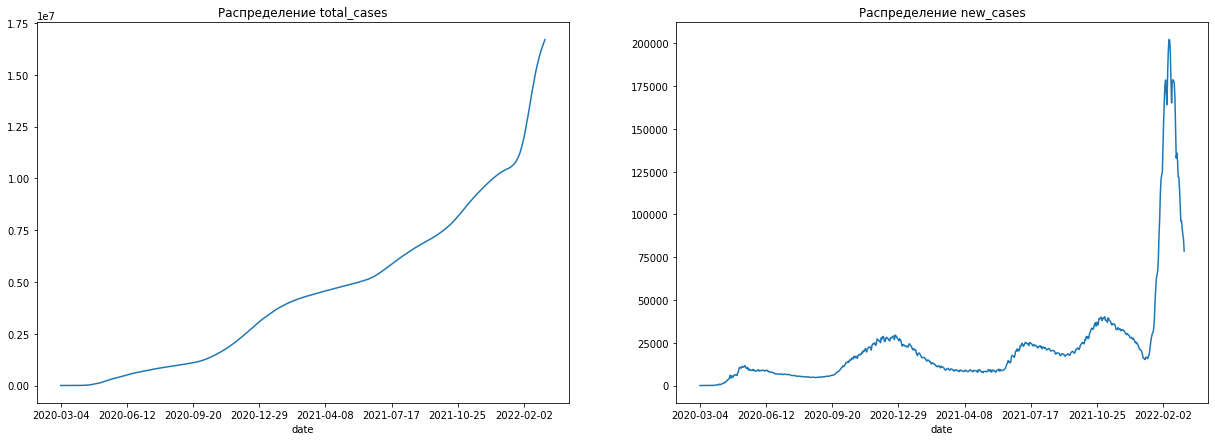

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

plot_data[targets[0]].plot(title=f'Распределение {targets[0]}', ax=axes[0])
plot_data[targets[1]].plot(title=f'Распределение {targets[1]}', ax=axes[1])

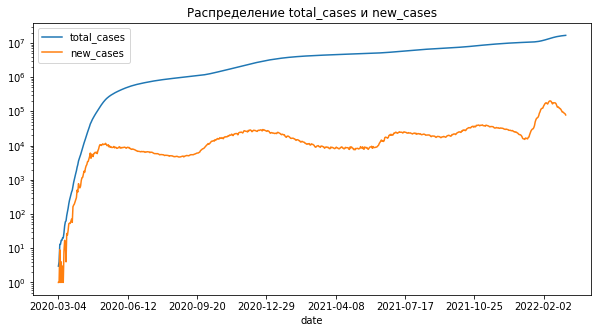

In [59]:
plot_data[targets].plot(title=f'Распределение {targets[0]} и {targets[1]}', figsize=(10, 5), logy=True)

Да, действительно, распределение количества заболевших имеет сходство с экпонентой или степенной функцией (возрастает быстро и выходит на плато). Прирост кол-ва заболевших, в свою очередь, более явно показывает волны, мы очтётливо видим 5 волн короны.

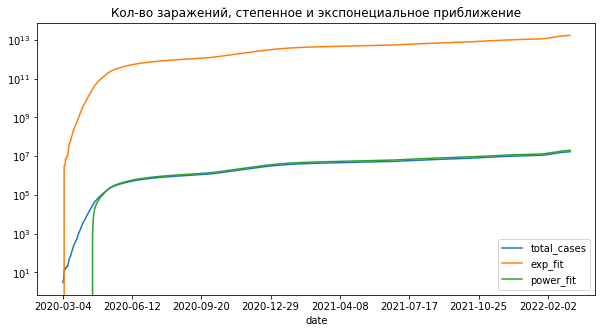

In [60]:
a1, b1 = np.polyfit(np.log(data[targets[0]]), data[targets[0]], 1)
a2, b2 = np.polyfit(np.power(data[targets[0]], 1 - 0.01), data[targets[0]], 1)

plot_data['exp_fit'] = (a1 * data[targets[0]] + b1).tolist()
plot_data['power_fit'] = (a2 * data[targets[0]] + b2).tolist()
plot_data[[targets[0], 'exp_fit', 'power_fit']].plot(title=f'Кол-во заражений, степенное и экспонециальное приближение', figsize=(10, 5), logy=True)
del a1, b1, a2, b2, plot_data

К счастью, мы уже заранее знаем, что рост не будет продолжаться вечно, поэтому мы сразу можем сказать, что кол-во заболевших от продолжительности эпидемии имеет не экпоненциальную зависимость.

## Разбивка не трейн и тест

In [77]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
data['duration_in_days'] = (data.index.values + 1).tolist()
train = data.loc[train_indices].copy()
test = data[~data.index.isin(train.index)].copy()
assert train.shape[0] == 50, 'Трейн не 50 дней'
assert train.shape[0] + test.shape[0] == data.shape[0], 'неправильный трейн или тест'

## Линейная регрессия. Экспонента (задание 2a)

Используя линейную регрессию, обучаем модель с экспоненциальным ростом числа заболевших: y = exp(f(x)) -> ln(y) = f(x)

In [78]:
target = targets[0]
features = ['duration_in_days']

In [79]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
x_train = train[features].values
y_train = train[target].values
y_train_log = np.log(y_train)

lr = LinearRegression().fit(x_train, y_train_log)

data[f'prediction_{target}'] = np.exp(lr.predict(data[features].values)).tolist()
print(f'Наклон: {lr.coef_}, смещение {lr.intercept_}')

Наклон: [0.1947175], смещение 1.9109596753423403


Только на логарифмическом масштабе можно рассмотреть, что на тесте ошибка становится очень большой. Мы как раз обучились на экпоненциальном росте, что и привело к такой ошибке (ну или, если точнее, то, что мы неправильно выбрали подходящую функцию, которая не описывает реальную зависимость)

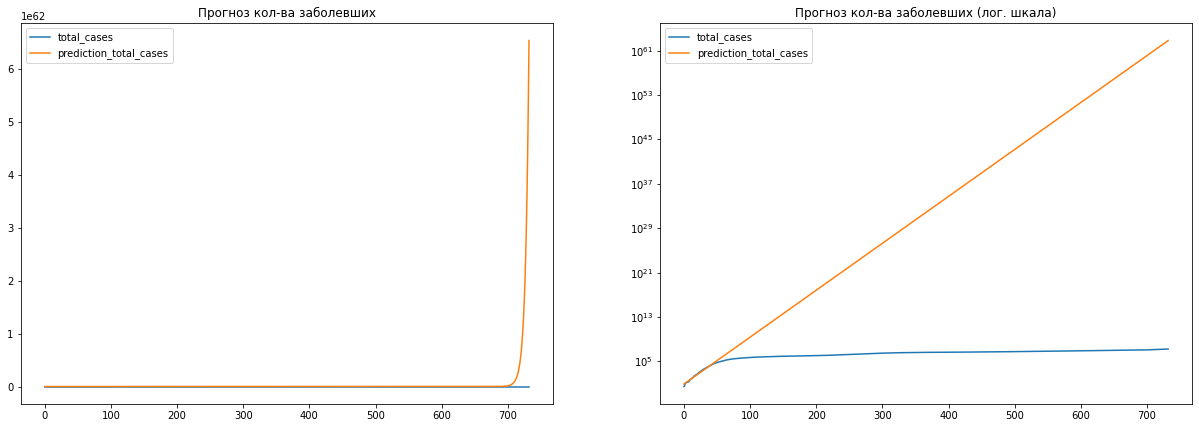

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

data[[target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших', ax=axes[0])
data[[target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших (лог. шкала)', logy=True, ax=axes[1])

При более крупном масштабе это более нагляден переход, когда начинается расхождение предсказаний и реальныз данных

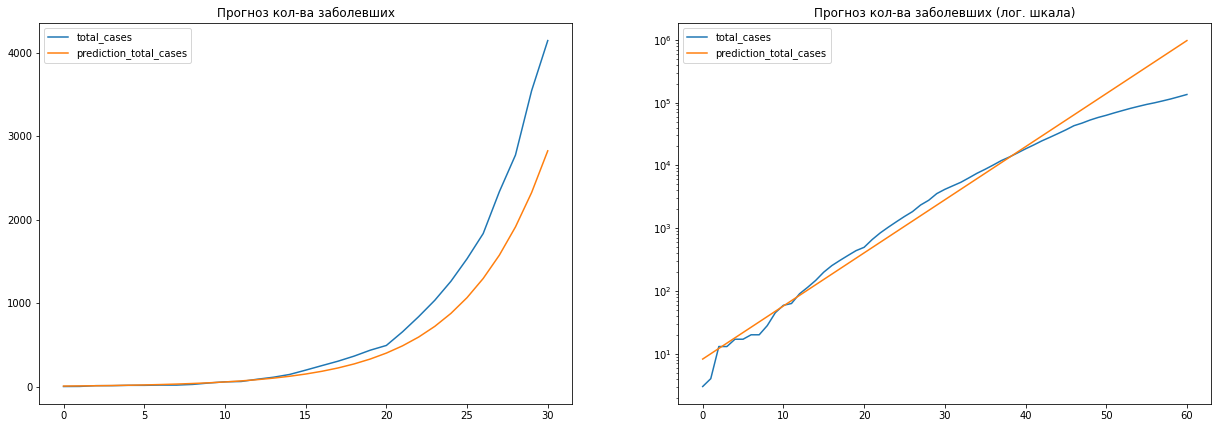

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

ax = data.loc[:30, [target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших', ax=axes[0])
data.loc[:60, [target, f'prediction_{target}']].plot(title='Прогноз кол-ва заболевших (лог. шкала)', logy=True, ax=axes[1])

##  Апостериорное распределение параметров модели для достаточно широкого априорного распределения (задание 2b)

In [94]:
sigma = (y_train_log - lr.predict(x_train)).var()
m = np.stack((x_train.flatten(), np.ones(len(x_train))), axis=1)
cov = np.linalg.inv(np.eye(2) / (sigma ** 2) + np.matmul(m.T, m) / sigma)
mu = np.matmul(np.matmul(cov, m.T), y_train_log.T) / sigma

print(f'Наклон: {mu[0]}, смещение {mu[1]}')

Наклон: 0.21765576553550156, смещение 1.137288105205331


## Сэмплы разных экспанент (задание 2с)

In [95]:
preds = []
dates = []

for year in [2020, 2021, 2022]:
    for month in [5, 6, 9]:
        dates.append((datetime.datetime(year, month, 1) - start_date).days)

for i in range(1000):
    pred = []
    for dt in dates:
        w1, w0 = np.random.multivariate_normal(mu, cov)
        pred.append(np.exp(w1 * dt + w0))
    preds.append(pred)
plt.show()

In [96]:
print("1 мая 2020 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 0]))))
print("1 июня 2020 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 1]))))
print("1 сентября 2020 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 2]))))
print("1 мая 2021 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 3]))))
print("1 июня 2021 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 4]))))
print("1 сентября 2021 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 5]))))
print("1 мая 2022 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 6]))))
print("1 июня 2022 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 7]))))
print("1 сентября 2022 предсказывается кол-во заболевших: {}".format(int(np.mean(np.array(preds)[:, 8]))))


1 мая 2020 предсказывается кол-во заболевших: 1187065
1 июня 2020 предсказывается кол-во заболевших: 1017981916
1 сентября 2020 предсказывается кол-во заболевших: 561811473517883456
1 мая 2021 предсказывается кол-во заболевших: 70349157373515762563063750111605882355712
1 июня 2021 предсказывается кол-во заболевших: 70210337517762576498365667991161331418923008
1 сентября 2021 предсказывается кол-во заболевших: 49889061997142136442826964106970452132247858952798208
1 мая 2022 предсказывается кол-во заболевших: 10838581909070739225151681206912835813401261815840863354742330104435687030784
1 июня 2022 предсказывается кол-во заболевших: 9461805981323382659048752004569775329388191367324413667420912090752825029558272
1 сентября 2022 предсказывается кол-во заболевших: 10590822606786653175263318843727290986425156526240780683771015124457907808839971561799680


В целом, мы выше уже видели, что экспоненциальный рост, по видению модели, будет продолжаться вечно, и в 2020 году уже должны были заболеть все люди, а в 2022 вообще все живые существа и по несколько раз

## Линейная регрессия. Сигмоида (задание 3)

total_cases - это куммулятивная сумма поля new_cases. Мы можем моделировать new_cases функцией плотности гауссианы. Для этого необходимо с помощью линейной регрессии обучить логарифм new_cases квадратичной функцией.

Для решения проблемы с экпоненциальным ростом мы можем обучать следующую линейную регрессию: ln(y) = a * x^2 + b * x + c, только y, в данном случае, - прирост, а не количество заболевших.

In [97]:
target = targets[1]

data['day_number'] = data.index.values + 1
data['day_number_pow2'] = np.power(data.index.values + 1, 2)

train = data.loc[train_indices].copy()
test = data[~data.index.isin(train.index)].copy()
assert train.shape[0] == 50, 'Трейн не 50 дней'
assert train.shape[0] + test.shape[0] == data.shape[0], 'неправильный трейн или тест'

In [98]:
# отсориторовано по дате, пропусков дат нет
# index 0 - 1ый день
x_train = train[['day_number', 'day_number_pow2']].values

y_train = train[target].values
y_train_log = np.log(y_train)

lr = LinearRegression().fit(x_train, y_train_log)

data[f'prediction_{target}'] = np.exp(lr.predict(data[['day_number', 'day_number_pow2']].values)).tolist()
print(f'Наклон: {lr.coef_}, смещение {lr.intercept_}')

Наклон: [ 0.28402043 -0.00198679], смещение -0.4888121596256143


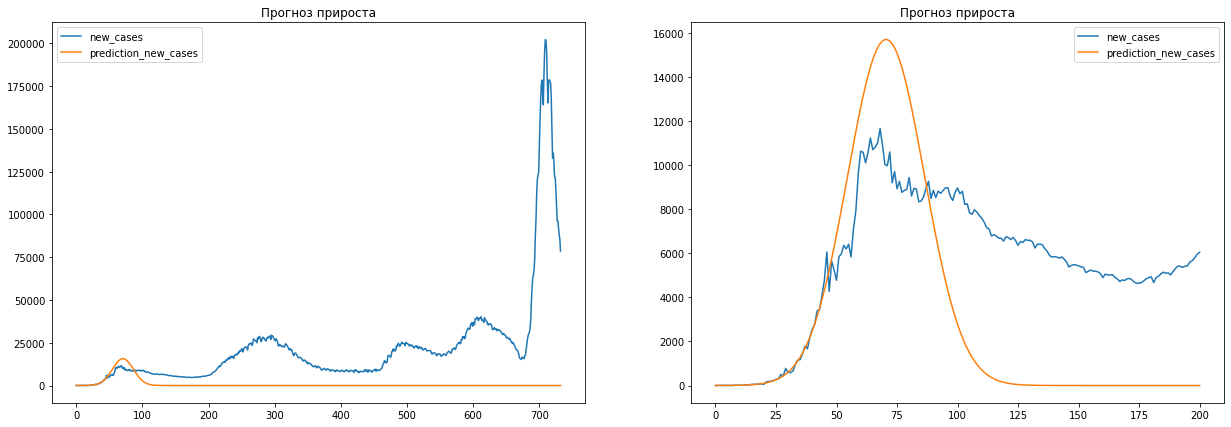

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

data[[target, f'prediction_{target}']].plot(title='Прогноз прироста', ax=axes[0])
data.loc[:200, [target, f'prediction_{target}']].plot(title='Прогноз прироста', ax=axes[1])